**классификатор kNN**


Евгений Борисов esborisov@sevsu.ru

---

# загрузка данных

In [1]:
import numpy as np
import pandas as pd

np.set_printoptions(precision=2) # ограничиваем точность float для печати

In [2]:
from sklearn.datasets import load_iris

ds = load_iris(as_frame=True)
display( ds.keys() )

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
print( ds['DESCR'] )

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [4]:
display( ds['feature_names'] )

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
target_names = ds['target_names'].tolist()
display( target_names )

['setosa', 'versicolor', 'virginica']

In [6]:
display( ds['frame'].sample(5) )

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
21,5.1,3.7,1.5,0.4,0
44,5.1,3.8,1.9,0.4,0
90,5.5,2.6,4.4,1.2,1
51,6.4,3.2,4.5,1.5,1
64,5.6,2.9,3.6,1.3,1


In [7]:
X = ds['data'].values
target = ds['target'].values

display( X.shape, target.shape, ) 

(150, 4)

(150,)

# рисуем данные

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

(150, 2)

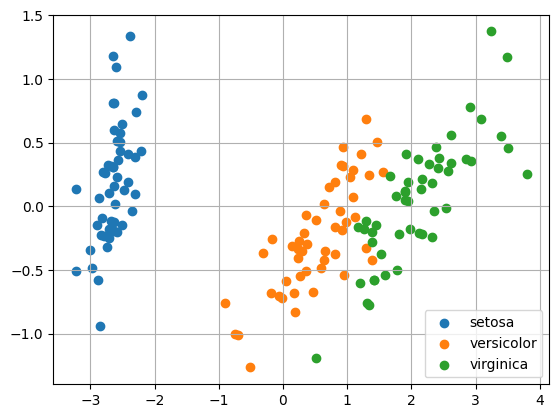

In [9]:
X2 = PCA(n_components=2).fit_transform(X)
display( X2.shape, ) 

fig,ax = plt.subplots()
for n,t in enumerate(target_names):
    ax.scatter( X2[target==n,0], X2[target==n,1], label=t, )
ax.legend()
ax.grid() 

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

http://www.machinelearning.ru/wiki/index.php?title=Профиль_компактности

In [11]:
# профиль компактности
def compact_profile(X,y,metric=euclidean_distances):
    r = metric(X) # матрица расстояний
    ri = np.argsort(r) # номера соседей в порядке увеличения расстояния 
    nc = y[ ri.flatten() ].reshape(r.shape) # номера классов для соседей в порядке увеличения расстояния 
    # инвертируем метку класса 1 для подсчёта точек-соседей из чужих классов
    nc = np.vstack([ (nc[ nc[:,0]==1 ]-1)*-1, nc[ nc[:,0]==0 ] ])
    # считаем чужих соседей k-тых в очереди удаления от объекта
    pc = np.asarray([ nc[:,k].sum() for k in range(1,nc.shape[1]) ])
    return pc/pc.max()

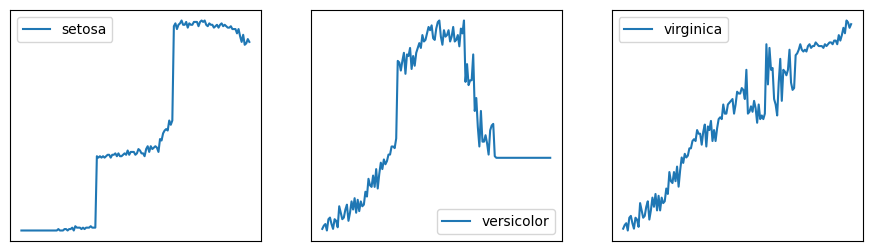

In [12]:
fig,ax = plt.subplots(1,len(target_names), sharey=False, sharex=False, figsize=(11,3),)
for n,t in enumerate(target_names):
    ax[n].plot( compact_profile( X, (target==n).astype(int) ), label=t )
    ax[n].legend()
    #ax[n].grid()
    ax[n].set_xticks([])
    ax[n].set_yticks([])

# классификация по ближайшим соседям

In [13]:
from numpy import random as rng
# случайно выберем примеры для классификации
ii = rng.permutation(range(len(X)))[:5] 
u,t = X[ ii,:], target[ii]
display( ii, u, t )

array([ 93,  65, 125,  82,  29])

array([[5. , 2.3, 3.3, 1. ],
       [6.7, 3.1, 4.4, 1.4],
       [7.2, 3.2, 6. , 1.8],
       [5.8, 2.7, 3.9, 1.2],
       [4.7, 3.2, 1.6, 0.2]])

array([1, 1, 2, 1, 0])

In [14]:
# матрица расстояний - расстояния от тестовых точек u до точек учебного набора X
d = euclidean_distances(u,X) 
display(d.shape)

(5, 150)

In [15]:
k = 3 # количество соседей
d_idx = np.argsort(d)[:,:k] # номера ближайших k соседей в порядке увеличения расстояния 
display(d_idx.shape)

(5, 3)

In [16]:
# заменяем индексы соседей на номера классов 
nc = target[ d_idx.flatten() ].reshape(d_idx.shape) 
display( nc ) # классы ближайших k соседей

array([[1, 1, 1],
       [1, 1, 1],
       [2, 2, 2],
       [1, 1, 1],
       [0, 0, 0]])

In [17]:
labels = sorted( set(target) ) # список номеров классов
display( labels )

[0, 1, 2]

In [18]:
# для каждого примера считаем количество соседей класса с 
knc = np.vstack([ 
    (nc==c).sum(axis=1) # сумма индикаторов класса с по строкам
    for c in labels # для каждого класса с
])

display( knc ) # матрица [ класс x пример : количество соседей ]

array([[0, 0, 0, 0, 3],
       [3, 3, 0, 3, 0],
       [0, 0, 3, 0, 0]])

In [19]:
# для каждого примера выбираем класс по преобладающим соседям 
p = np.argmax( knc,axis=0 )
display( p ) # результат классификатора

array([1, 1, 2, 1, 0])

In [20]:
display( t ) # метки примеров

array([1, 1, 2, 1, 0])

# модель классификатора

In [21]:
# sklearn.neighbors.KNeighborsClassifier

In [22]:
class KNeighborsClassifier:
    
    def __init__(self,metric=euclidean_distances,k=3):
        self._metric = metric
        self._k = k
        self._X = np.array([])
        self._label = np.array([])
                
    def fit(self,X,target):
        assert len(X.shape)==2
        assert len(target.shape)==1
        assert len(set(target))>1
        assert len(X)==len(target)  
        
        self._X = X
        self._label = target
        return self

    def predict(self, x):
        assert len(self._X)>1
        assert self._X.shape[1]==x.shape[1]
        
        d = self._metric(x,self._X) # расстояния от тестовых точек u до точек учебного набора X
        d_idx = np.argsort(d)[:,:self._k] # номера k соседей в порядке увеличения расстояния 
        # заменяем индексы соседей на номера классов 
        nc = self._label[ d_idx.flatten() ].reshape(d_idx.shape) 
        knc = np.vstack([ 
                (nc==c).sum(axis=1) # сумма индикаторов класса с по строкам
                for c in labels # для каждого класса с
            ])
        return np.argmax( knc,axis=0 ) # метки примеров

## тестируем классификатор

In [23]:
# обучаем классификатор
model = KNeighborsClassifier().fit(X,target)

In [24]:
from sklearn.metrics import accuracy_score

# тестируем классификатор
predicted = model.predict(X)

# доля правильных ответов
display( accuracy_score(y_true=target, y_pred=predicted, ) )

0.96

---

In [25]:
# !pip3 install watermark
%load_ext watermark
%watermark --python
%watermark --iversions

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.21.0

matplotlib: 3.8.2
pandas    : 2.2.0
numpy     : 1.26.3

